# Background
Getting the path, loading the train/valid and creating datablock

~Create a python enviroment version 3.11.8 is possible then install everything in requirements.txt~

In [5]:
# pointing to the dataset directory on Google Drive
path = 'bone_fracture_dataset_splitted'

path

'bone_fracture_dataset_splitted'

In [6]:
import yaml

with open(path+'/data.yaml', 'r') as f:
    data_structure = yaml.safe_load(f)
    print(data_structure)

{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 7, 'names': ['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive'], 'roboflow': {'workspace': 'veda', 'project': 'bone-fracture-detection-daoon', 'version': 4, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/veda/bone-fracture-detection-daoon/dataset/4'}}


In [12]:
from fastai.vision.all import *
import yaml
import pandas as pd
import warnings

data_dir = Path(path)
trainValid_image_path = data_dir/'trainValid/images'
trainValid_label_path = data_dir/'trainValid/labels'

# The class names are directly taken from the YAML file
class_names = data_structure['names']

def get_label(file_path):
    # Construct the filename for the label file by removing the image extension and appending .txt
    label_file_name = '.'.join(str(file_path.name).split('.')[:-1]) + '.txt'
    label_file_path = trainValid_label_path/label_file_name

    # Attempt to open the corresponding label file
    with open(label_file_path, 'r') as label_file:

        #print(label_file_path)

        label_values = label_file.read().split(' ')
        label = label_values[0]  # Assuming the first item is the label index

        #print(label)

        if not label:
            return 'N'
        return class_names[int(label)]

# Setting up the FastAI DataBlock
bone_fractures = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.5, seed=42),
    get_y=get_label,
    item_tfms=Resize(256),
    batch_tfms=aug_transforms(size=256, min_scale=0.75)
)

# Load the data
dls = bone_fractures.dataloaders(trainValid_image_path, bs=64)

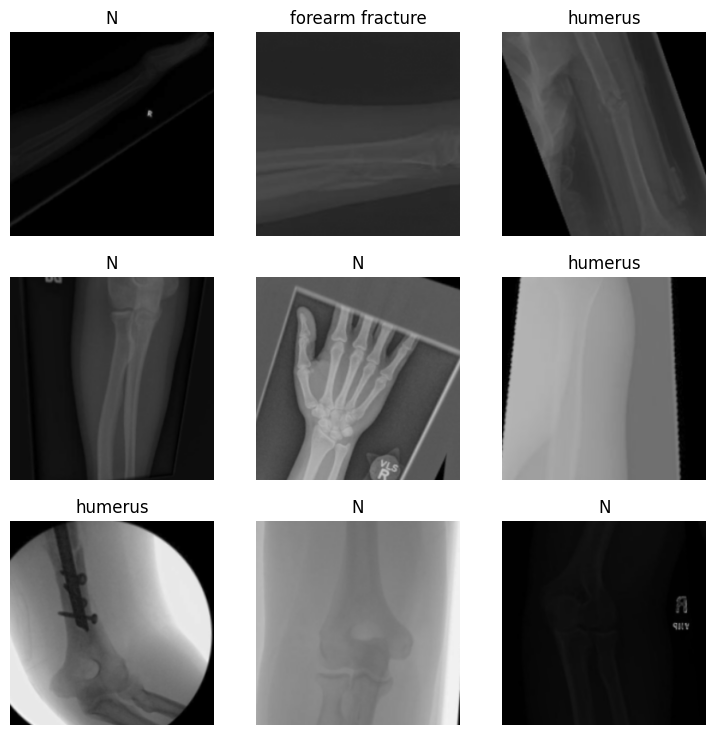

In [13]:
# Show an example
dls.show_batch()

# Counting the classes
(issue atm... N has 2002 but humerus fracture is missing now, why?)

In [14]:
from collections import Counter
import os

# Initialize a counter for all labels, including 'N'
label_counter = Counter()

# Function to update the counter based on the label of each file
def update_label_counter(file_path):
    label_file_name = '.'.join(str(file_path.name).split('.')[:-1]) + '.txt'
    label_file_path = trainValid_label_path / label_file_name
    
    label = 'N'  # Default to 'N'
    with open(label_file_path, 'r') as label_file:
        label_values = label_file.read().strip().split(' ')
        if label_values[0].isdigit():
            label_index = int(label_values[0])
            if label_index < len(class_names):
                label = class_names[label_index]

    # Update the counter
    label_counter[label] += 1

# Iterate over image files to update the counter
image_files = get_image_files(trainValid_image_path)
for image_file in image_files:
    update_label_counter(image_file)

# Display the count for each label, including 'N'
print(f"Label counts: {label_counter}")

Label counts: Counter({'N': 2002, 'fingers positive': 474, 'elbow positive': 334, 'shoulder fracture': 334, 'humerus': 330, 'forearm fracture': 320, 'wrist positive': 185})


# Simple cnn

In [26]:
# Define a simple CNN using FastAI
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1) # Assuming 3-channel (RGB) input images
        self.act1 = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.fc1 = nn.Linear(32 * 64 * 64, 512) # Adjust the input features based on your image size and architecture
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.pool(self.act1(self.conv1(x)))
        x = self.pool(self.act2(self.conv2(x)))
        x = torch.flatten(x, 1) # Flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Adjust 'num_classes' to match the number of categories in your dataset
model = SimpleCNN(num_classes=7)

# Creating weighted classes so its "balanced"
(Currently working on this part)

In [57]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Assuming 'class_names' includes all your valid labels as earlier defined
class_names = ['N', 'elbow positive', 'fingers positive', 'forearm fracture', 'humerus', 'shoulder fracture', 'wrist positive']

# Updated class frequencies to reflect your Counter data
class_freqs = np.array([2002, 334, 474, 320, 330, 334, 185])

# Classes indices should range from 0 to number of classes - 1
class_indices = np.arange(len(class_names))

# Calculate class weights for all valid labels in 'y'
class_weights = compute_class_weight('balanced', classes=class_indices, y=class_freqs)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Ensure the tensor is on the correct device (CPU or GPU)
class_weights_tensor = class_weights_tensor.to(dls.device)

# Define the loss function with class weights
loss_func = CrossEntropyLossFlat(weight=class_weights_tensor)

# Create a Learner with the custom loss function
learn = Learner(dls, model, loss_func=loss_func, metrics=accuracy)

ValueError: classes should include all valid labels that can be in y

SuggestedLRs(valley=0.00013182566908653826)

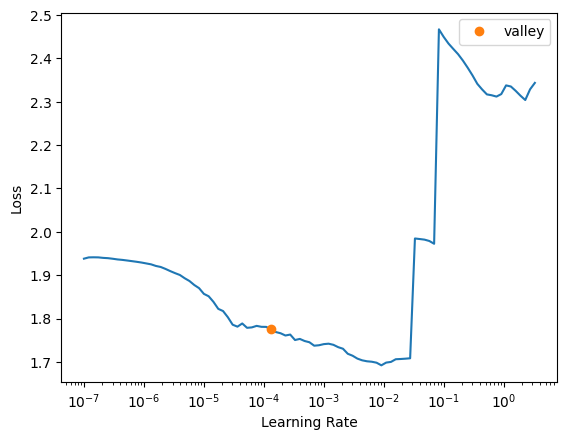

In [28]:
# Find an appropriate learning rate
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.601452,1.571073,0.500000,01:31


Better model found at epoch 0 with valid_loss value: 1.5710728168487549.


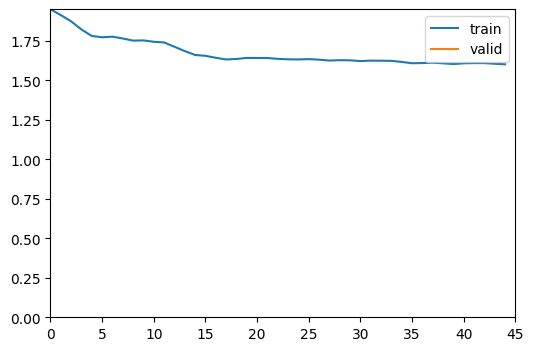

epoch,train_loss,valid_loss,accuracy,time
0,1.533182,1.548553,0.500000,01:33
1,1.517349,1.528574,0.500000,01:30
2,1.505250,1.513759,0.500000,01:30
3,1.503343,1.503783,0.500000,01:30
4,1.489695,1.489163,0.500000,01:31


Better model found at epoch 0 with valid_loss value: 1.548553228378296.


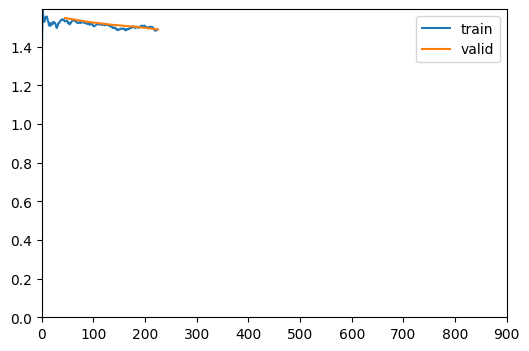

Better model found at epoch 1 with valid_loss value: 1.5285735130310059.
Better model found at epoch 2 with valid_loss value: 1.5137592554092407.
Better model found at epoch 3 with valid_loss value: 1.5037834644317627.
Better model found at epoch 4 with valid_loss value: 1.489162802696228.


KeyboardInterrupt: 

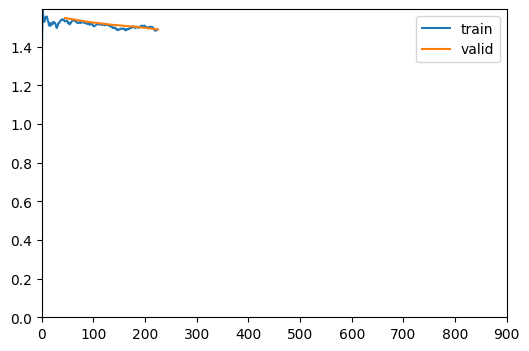

In [9]:
learn.fine_tune(20, 0.0002754228771, cbs=[ShowGraphCallback(), EarlyStoppingCallback(min_delta=0.001, patience=10), SaveModelCallback()])

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\James/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 62.4MB/s]


SuggestedLRs(valley=0.001737800776027143)

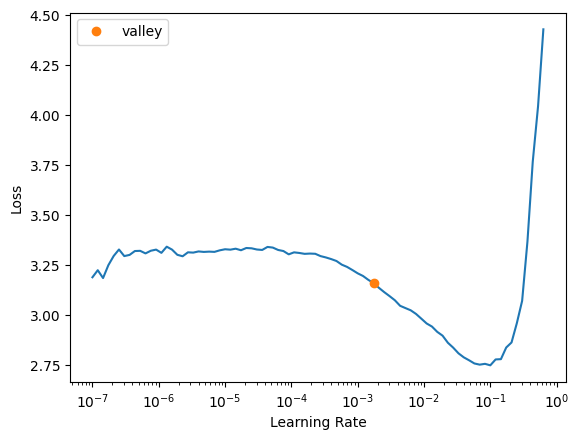

In [13]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.lr_find()

# Resnet 34 Test

epoch,train_loss,valid_loss,accuracy,time
0,2.533420,1.389909,0.522039,03:28


Better model found at epoch 0 with valid_loss value: 1.3899086713790894.


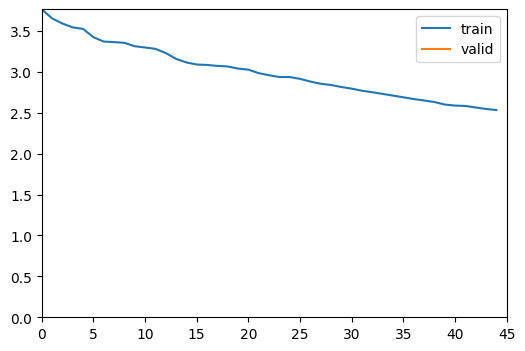

epoch,train_loss,valid_loss,accuracy,time
0,1.702201,1.173983,0.590909,04:27
1,1.480214,0.985097,0.679063,04:25
2,1.267411,0.820619,0.712121,04:24
3,1.061523,0.718485,0.756198,04:24
4,0.893115,0.700592,0.772727,04:24
5,0.761202,0.606572,0.790634,04:25
6,0.666370,0.563790,0.814050,04:38
7,0.581693,0.474505,0.829201,04:44
8,0.502331,0.525417,0.823691,04:31
9,0.428330,0.470096,0.844353,04:31


Better model found at epoch 0 with valid_loss value: 1.173982858657837.


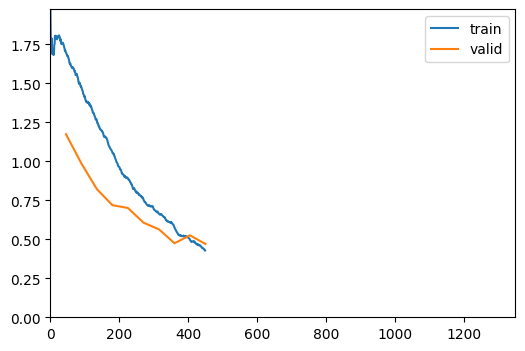

Better model found at epoch 1 with valid_loss value: 0.9850967526435852.
Better model found at epoch 2 with valid_loss value: 0.8206188678741455.
Better model found at epoch 3 with valid_loss value: 0.7184853553771973.
Better model found at epoch 4 with valid_loss value: 0.7005919218063354.
Better model found at epoch 5 with valid_loss value: 0.6065719127655029.
Better model found at epoch 6 with valid_loss value: 0.5637900233268738.
Better model found at epoch 7 with valid_loss value: 0.4745045304298401.
Better model found at epoch 9 with valid_loss value: 0.470096230506897.


KeyboardInterrupt: 

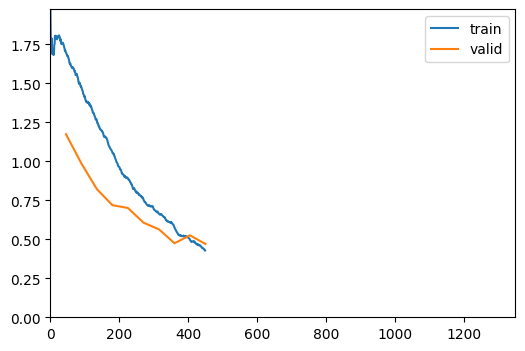

In [14]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(30, 0.001737800776027143, cbs=[ShowGraphCallback(), EarlyStoppingCallback(min_delta=0.001, patience=10), SaveModelCallback()])

# Displaying the results of model

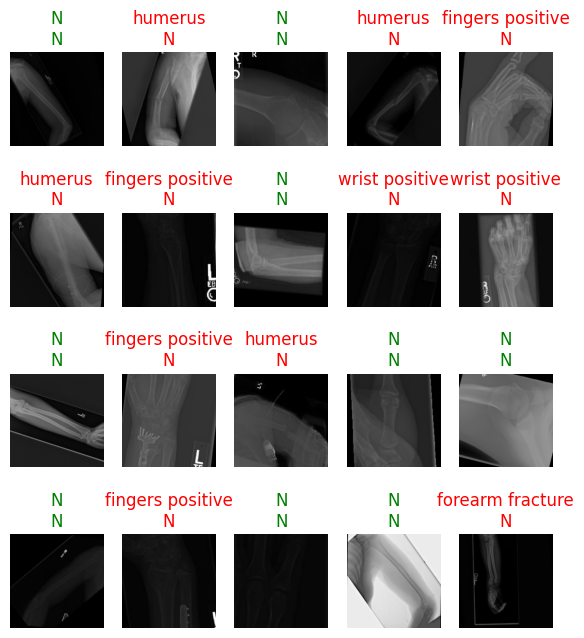

In [10]:
# visualize results (top row: true labels, bottom row: predicted labels)
learn.show_results(max_n = 20, figsize=(7,8))